In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from matplotlib import pyplot as plt
from collections import deque, namedtuple
from copy import deepcopy
from gym import make

In [2]:
SEED = 42
GAMMA = 0.99

MEMORY_SIZE = int(1e5)
BATCH_SIZE = 512
MAX_STEPS = int(1e3)

LR_ACTOR =  2e-4
LR_CRITIC = 2e-3
TAU = 1e-3

EPSILON_MAX = 1.0
EPSILON_MIN = 1e-3
EPSILON_DECAY = 1e-3

ENV = 'MountainCarContinuous-v0'

### ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ И КЛАССЫ

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Transition = namedtuple('Transition',
    ['state', 'action', 'next_state', 'reward', 'done']
)


def OUNoise(size, mu=0, theta=0.3, sigma=0.6):
    state = mu * np.ones(size)
    while True:
        yield state
        state += -theta * state + sigma * np.array([np.random.randn() for i in range(size)])

        
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)


class ReplayMemory(deque):
    def get_batch(self):
        def wrap(x):
            return torch.tensor(x).to(device)
        
        
        transitions = random.sample(self, BATCH_SIZE)
        return Transition(
            *map(wrap, zip(*transitions))
        )
    
    

### РЕАЛИЗАЦИЯ DDPG

#### Actor

In [31]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, fc1_units=32, fc2_units=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_dim)

        #self._init_weights()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))

        return x


    def _init_weights(self):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)





#### Critic

In [32]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, fc1_units=16, fc2_units=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_dim, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

        #self._init_weights()


    def forward(self, x_s, x_a):
        x = F.relu(self.fc1(x_s))
        x = torch.cat((x, x_a), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


    def _init_weights(self):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)



#### DDPG Agent

In [33]:
class Agent:
    def __init__(self, state_dim, action_dim, soft_update_coef=TAU):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = GAMMA
        self.tau = soft_update_coef

        self.memory = ReplayMemory(maxlen=MEMORY_SIZE)

        self.actor_local = Actor(state_dim, action_dim).to(device)
        self.actor_target = deepcopy(self.actor_local)
        self.actor_target.eval()
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_dim, action_dim).to(device)
        self.critic_target = deepcopy(self.critic_local)
        self.critic_target.eval()
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)


    def update(self):
        if len(self.memory) < BATCH_SIZE:
            return 0, 0
        
        self.actor_local.train()
        self.critic_local.train()

        batch = self.memory.get_batch()
        state_b = batch.state.float()
        action_b = batch.action.float()
        next_state_b = batch.next_state.float()
        reward_b = batch.reward.unsqueeze(1)
        done_b = batch.done.unsqueeze(1)
        
        # ------------------------ critic update ------------------------ # 
        next_action_b = self.actor_target(next_state_b).detach()
        Q_next = self.critic_target(next_state_b, next_action_b)
        Q_target = reward_b + self.gamma * Q_next * (~done_b).float()      
        Q_predicted = self.critic_local(state_b, action_b)
    
        critic_loss = F.mse_loss(Q_predicted, Q_target)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self._clamp_parameters(self.critic_local.parameters())
        self.critic_optimizer.step()

        # ------------------------ actor update ------------------------ #
        actor_loss = -self.critic_local(state_b, self.actor_local(state_b)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self._clamp_parameters(self.actor_local.parameters())
        self.actor_optimizer.step()

        self.update_targets()
        
        return actor_loss.item(), critic_loss.item()
    
    
    def act(self, state):
        state = torch.tensor(state, dtype=torch.float).to(device).unsqueeze(0)
        action = self.actor_local(state).detach()

        return action.cpu().data.numpy()


    def save(self):
        torch.save(self.actor_local.state_dict(), 'actor.pkl')
        torch.save(self.critic_local.state_dict(), 'critic.pkl')


    def update_targets(self):
        self._soft_update_target(self.actor_target, self.actor_local)
        self._soft_update_target(self.critic_target, self.critic_local)
        self.actor_target.eval()
        self.critic_target.eval()


    def _clamp_parameters(self, params):
        for param in params:
            if param.grad is not None:
                param.grad.data.clamp_(-1.0, 1.0)


    def _soft_update_target(self, target_model, local_model):
        for t_param, l_param in zip(target_model.parameters(), local_model.parameters()):
            t_param.data.copy_(self.tau * l_param.data + (1.0 - self.tau) * t_param.data)

    

In [35]:
class Game:
    def __init__(self, agent, env=ENV, n_train_episodes=200, n_test_episodes=100):
        self.env = make('MountainCarContinuous-v0')
        self.env.seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        
        self.agent = agent
        self.n_train = n_train_episodes
        self.n_test = n_test_episodes
        self.eps = EPSILON_MAX
        
        
    def train(self):
        scores = []
        prev_reward = float('-inf')
        mean_reward = saved_mean = 0
        
        for episode in range(self.n_train):
            state = np.array(self.env.reset(), dtype=np.float32).squeeze()

            actor_loss = critic_loss = 0
            total_reward = 0
            steps = 0
            noise = OUNoise(self.agent.action_dim)
            self.eps = max(self.eps - EPSILON_DECAY, EPSILON_MIN)

            done = False
            while not done:
                action = self.agent.act(state) + self.eps * next(noise)
                action = np.clip(action, -1.0, 1.0)

                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32).squeeze()
                total_reward += reward

                self.agent.memory.append(
                    Transition(state, action[0], next_state, reward, done)
                )
                state = next_state

                loss_a, loss_c = self.agent.update()
                actor_loss += loss_a
                critic_loss += loss_c

                steps += 1
                if steps > MAX_STEPS:
                    break

            scores.append(total_reward)
            if len(scores) > 10:
                mean_reward = np.mean(scores[-10:])

            if total_reward > 90.0 and mean_reward > max(saved_mean, 90.0):
                    saved_mean = mean_reward
                    self.agent.save()
                    print('################## -- SAVED -- ##################')

            print(f'episode #{episode} with reward {total_reward}')
            if len(scores) > 10:
                print(f'mean reward for last 10 episodes = {mean_reward}', end='\n\n')
       
        return scores
                
                
    def test(self):
        scores = []
        self.agent.actor_local.load_state_dict(torch.load('actor.pkl'))
        self.agent.actor_local.eval()
        self.agent.actor_local.to(device)
        for ep in range(self.n_test):
            state = self.env.reset()
            total_reward = 0

            done = False
            while not done:
                if ep > self.n_test - 10:
                    self.env.render()

                state = np.array(state, dtype=np.float).squeeze()
                action = self.agent.act(state)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                
            self.env.close()
            scores.append(total_reward)

        print(f'mean reward for {self.n_test} episodes = ', np.mean(scores))

    

## Создадим агента и игру

In [36]:
agent = Agent(state_dim=2, action_dim=1)
game = Game(agent)

### Тренировка

In [37]:
scores = game.train()

episode #0 with reward -42.09461905269763
episode #1 with reward -44.84877907005654
episode #2 with reward 86.79760310494125
episode #3 with reward 68.41251723339296
episode #4 with reward -48.62084215626104
episode #5 with reward 85.15153302711325
episode #6 with reward 87.40862555816467
episode #7 with reward 51.49246529327772
episode #8 with reward -53.99790043590273
episode #9 with reward -56.90320722934984
episode #10 with reward -58.011960851086435
mean reward for last 10 episodes = 11.688005447423327

episode #11 with reward -48.93336442178366
mean reward for last 10 episodes = 11.279546912250614

episode #12 with reward 67.78956881636711
mean reward for last 10 episodes = 9.3787434833932

episode #13 with reward -59.364648811318396
mean reward for last 10 episodes = -3.3989731210779346

episode #14 with reward 68.84466396737292
mean reward for last 10 episodes = 8.34757749128546

episode #15 with reward 80.85195373884841
mean reward for last 10 episodes = 7.917619562458978

epi

SCORES

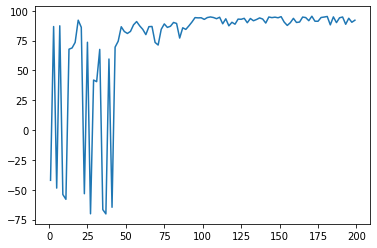

In [38]:
%matplotlib inline
plt.plot([i + 1 for i in range(0, len(scores), 2)], scores[::2])
plt.show()

#### Test

In [39]:
game.test()

mean reward for 100 episodes =  93.46120839669643
